In [47]:
import numpy as np
import scipy.io as sio
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Shapes before tProduct: U=(49, 49), S=(49, 49), VT=(49, 4205000)
Shape after first tProduct (C): (49, 4205000)
Shape after second tProduct (Feacube_proc): (49, 21025, 200)


C:\Users\Mrlaptop\AppData\Local\Temp\ipykernel_3120\627862237.py:117: RuntimeWarning: invalid value encountered in divide
  New_pad_img /= repeat[:, :, None]


[  0.          26.59042173  26.07626076   0.          24.94714588
  51.46853147   0.          14.31623932   0.          17.43697479
  87.48440748   3.61445783  39.          81.0330912    0.52910053
   1.0989011   44.96363455  23.34972076 -22.40194992]


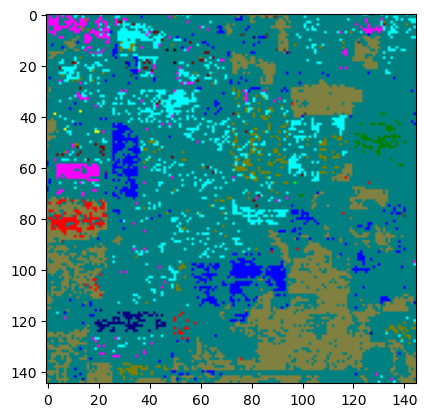

In [62]:
import numpy as np
import scipy.io as sio
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def tSVD(tensor, rank):
    """ Tensor Singular Value Decomposition """
    unfold_tensor = tensor.reshape(tensor.shape[0], -1)
    U, S, VT = np.linalg.svd(unfold_tensor, full_matrices=False)
    U = U[:, :rank]
    S = np.diag(S)[:rank, :rank]
    VT = VT[:rank, :]
    return U, S, VT

def tProduct(U, S, VT):
    """ Tensor Product """
    result = np.tensordot(U, S, axes=(1, 0))
    result = np.tensordot(result, VT, axes=(1, 0))
    return result

def label2color(SVMresult, dataset):
    """ Convert labels to RGB colors for visualization """
    if dataset == 'india':
        colormap = np.array([
            [0, 0, 0], [0, 255, 0], [0, 255, 255], [255, 0, 255],
            [255, 255, 0], [255, 0, 0], [0, 0, 255], [128, 128, 128],
            [0, 128, 0], [128, 0, 128], [128, 128, 0], [0, 128, 128],
            [128, 0, 0], [0, 0, 128], [128, 128, 64], [64, 64, 64]
        ])
    elif dataset == 'uni':
        # Define color map for Pavia University
        pass
    elif dataset == 'muufl':
        # Define color map for MUUFL Gulfport
        pass
    else:
        raise ValueError("Unknown dataset")

    SVMmap = colormap[SVMresult % colormap.shape[0]]
    return SVMmap

# Load dataset
img_gt = sio.loadmat("C:/Users/Mrlaptop/Downloads/TensorSSA-main-Hasiba (2)/TensorSSA-main/HSIdata/Indian_pines_gt.mat")['indian_pines_gt']
img = sio.loadmat("C:/Users/Mrlaptop/Downloads/TensorSSA-main-Hasiba (2)/TensorSSA-main/HSIdata/Indian_pines_corrected.mat")['indian_pines_corrected']

#img_gt = sio.loadmat("C:/Users/Mrlaptop/Downloads/TensorSSA-main-Hasiba (2)/TensorSSA-main/HSIdata/MUUFL_Gulfport_gt.mat")['MUUFL_Gulfport_gt']
#img = sio.loadmat("C:/Users/Mrlaptop/Downloads/TensorSSA-main-Hasiba (2)/TensorSSA-main/HSIdata/MUUFL_Gulfport.mat")['MUUFL_Gulfport']
W, H, B = img.shape


# Parameters (Can be changed as required)
u = 5
w = 2 * u + 1
w2 = w * w
L = 49

# TensorSSA
indian_pines = np.pad(img, ((u, u), (u, u), (0, 0)), mode='symmetric')
Id = np.zeros((L, W * H), dtype=int)
Fea_cube = np.zeros((L, W * H, B))

# Adaptive embedding
k = 0
for i in range(W):
    for j in range(H):
        i1 = i + u
        j1 = j + u
        k += 1
        testcube = indian_pines[i1-u:i1+u+1, j1-u:j1+u+1, :]
        m = testcube.reshape(w2, B)

        # NED
        center = m[(w2+1)//2, :]
        NED = np.sqrt(np.sum(((m / np.linalg.norm(m, axis=1, keepdims=True)) - (center / np.linalg.norm(center)))**2, axis=1))
        ind = np.argsort(NED)
        index = ind[:L]
        Id[:, k-1] = index
        Fea_cube[:, k-1, :] = m[index, :]

# T-SVD decomposition
rank = min(L, B)  # Ensure the rank is appropriate for the tensor dimensions
U, S, VT = tSVD(Fea_cube, rank)

# Ensure shapes are compatible for tProduct
print(f"Shapes before tProduct: U={U.shape}, S={S.shape}, VT={VT.shape}")
assert U.shape[1] == S.shape[0]
assert S.shape[1] == VT.shape[0]

C = tProduct(U, S, VT)
print(f"Shape after first tProduct (C): {C.shape}")

# Perform the final tProduct
Feacube_proc = C.reshape(L, W * H, B)
print(f"Shape after second tProduct (Feacube_proc): {Feacube_proc.shape}")

# Reprojection
New_pad_img = np.zeros((W+w-1, H+w-1, B))
repeat = np.zeros((W+w-1, H+w-1))
kk = 0
for i in range(W):
    for j in range(H):
        kk += 1
        rec_m = np.zeros((w2, B))
        rec_m[Id[:, kk-1], :] = Feacube_proc[:, kk-1, :]
        dd = rec_m.reshape(w, w, B)

        rec_col = np.zeros(w2)
        rec_col[Id[:, kk-1]] = 1

        i1 = i + u
        j1 = j + u
        New_pad_img[i1-u:i1+u+1, j1-u:j1+u+1, :] += dd
        repeat[i1-u:i1+u+1, j1-u:j1+u+1] += rec_col.reshape(w, w)

New_pad_img /= repeat[:, :, None]
img_tensorSSA = New_pad_img[u:W+u, u:H+u, :]

# SVM based classification
Labels = img_gt.reshape(W*H)
Vectors = img_tensorSSA.reshape(W*H, B)
class_num = np.max(img_gt) - np.min(img_gt)
trainVectors, trainLabels, testVectors, testLabels = [], [], [], []

rng = np.random.default_rng()
Sam = 0.02  # Training sample ratio: 0.02 for IP, 0.01 for PU and MG

for k in range(1, class_num + 1):
    index = np.where(Labels == k)[0]
    perclass_num = len(index)
    Vectors_perclass = Vectors[index, :]
    c = rng.permutation(perclass_num)
    select_train = Vectors_perclass[c[:int(np.ceil(perclass_num * Sam))], :]
    train_index_k = index[c[:int(np.ceil(perclass_num * Sam))]]
    trainVectors.append(select_train)
    trainLabels.extend([k] * int(np.ceil(perclass_num * Sam)))

    select_test = Vectors_perclass[c[int(np.ceil(perclass_num * Sam)):], :]
    test_index_k = index[c[int(np.ceil(perclass_num * Sam)):]]
    testVectors.append(select_test)
    testLabels.extend([k] * (perclass_num - int(np.ceil(perclass_num * Sam))))

trainVectors = np.vstack(trainVectors)
testVectors = np.vstack(testVectors)

# Feature scaling
scaler = StandardScaler().fit(trainVectors)
trainVectors = scaler.transform(trainVectors)
testVectors = scaler.transform(testVectors)
Vectors = scaler.transform(Vectors)

# SVM training
Ccv = 1000
Gcv = 0.125
model = SVC(C=Ccv, gamma=Gcv)
model.fit(trainVectors, trainLabels)

# SVM test
testLabel_est = model.predict(testVectors)

# Convert testLabel_est to match testLabels if necessary


# Find unique labels in both testLabels and testLabel_est
unique_labels_testLabels = np.unique(testLabels)
unique_labels_testLabel_est = np.unique(testLabel_est)

# Map testLabel_est to match testLabels
testLabel_est_mapped = np.zeros_like(testLabel_est)
for i, label in enumerate(unique_labels_testLabel_est):
    if label in unique_labels_testLabels:
        testLabel_est_mapped[testLabel_est == label] = label
    else:
        testLabel_est_mapped[testLabel_est == label] = 0  # Replace with a placeholder label (0 or any unused label)

# Ensure the shapes match for confusion matrix calculation
if len(np.unique(testLabel_est_mapped)) > len(unique_labels_testLabels):
    testLabel_est_mapped = testLabel_est_mapped[:-1]

# Performance evaluation with mapped labels
OA = np.mean(testLabels == testLabel_est_mapped)
conf_mat = confusion_matrix(testLabels, testLabel_est_mapped)
CA = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
AA = np.mean(CA)
kappa = (OA - (1 - OA)) / (1 - (1 - OA))

ACC = np.hstack([CA * 100, OA * 100, AA * 100, kappa * 100])
print(ACC)

# Further processing or visualization as needed

SVMresult = model.predict(Vectors)
SVMresult = SVMresult.reshape(W, H)
SVMmap = label2color(SVMresult, 'india')  # For IP
# SVMmap = label2color(SVMresult, 'uni')  # For PU
# SVMmap = label2color(SVMresult, 'muufl')  # For MG

plt.imshow(SVMmap)
plt.show()


# indian pins

# MUUFL_GULFPORT

In [50]:
import numpy as np
import scipy.io as sio
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

def tSVD(tensor, rank):
    """ Tensor Singular Value Decomposition """
    unfold_tensor = tensor.reshape(tensor.shape[0], -1)
    U, S, VT = np.linalg.svd(unfold_tensor, full_matrices=False)
    U = U[:, :rank]
    S = np.diag(S)[:rank, :rank]
    VT = VT[:rank, :]
    return U, S, VT

def tProduct(U, S, VT):
    """ Tensor Product """
    result = np.tensordot(U, S, axes=(1, 0))
    result = np.tensordot(result, VT, axes=(1, 0))
    return result

# Load dataset
img_gt = sio.loadmat("C:/Users/Mrlaptop/Downloads/TensorSSA-main-Hasiba (2)/TensorSSA-main/HSIdata/MUUFL_Gulfport_gt.mat")['MUUFL_Gulfport_gt']
img = sio.loadmat("C:/Users/Mrlaptop/Downloads/TensorSSA-main-Hasiba (2)/TensorSSA-main/HSIdata/MUUFL_Gulfport.mat")['MUUFL_Gulfport']

#img_gt = sio.loadmat("C:/Users/Mrlaptop/Downloads/TensorSSA-main-Hasiba (2)/TensorSSA-main/HSIdata/Indian_pines_gt.mat")['indian_pines_gt']
#img = sio.loadmat("C:/Users/Mrlaptop/Downloads/TensorSSA-main-Hasiba (2)/TensorSSA-main/HSIdata/Indian_pines_corrected.mat")['indian_pines_corrected']


W, H, B = img.shape

# Parameters (Can be changed as required)
u = 5
w = 2 * u + 1
w2 = w * w
L = 49

# TensorSSA
indian_pines = np.pad(img, ((u, u), (u, u), (0, 0)), mode='symmetric')
Id = np.zeros((L, W * H), dtype=int)
Fea_cube = np.zeros((L, W * H, B))

# Adaptive embedding
k = 0
for i in range(W):
    for j in range(H):
        i1 = i + u
        j1 = j + u
        k += 1
        testcube = indian_pines[i1-u:i1+u+1, j1-u:j1+u+1, :]
        m = testcube.reshape(w2, B)

        # NED
        center = m[(w2+1)//2, :]
        NED = np.sqrt(np.sum(((m / np.linalg.norm(m, axis=1, keepdims=True)) - (center / np.linalg.norm(center)))**2, axis=1))
        ind = np.argsort(NED)
        index = ind[:L]
        Id[:, k-1] = index
        Fea_cube[:, k-1, :] = m[index, :]

# T-SVD decomposition
rank = min(L, B)  # Ensure the rank is appropriate for the tensor dimensions
U, S, VT = tSVD(Fea_cube, rank)

# Ensure shapes are compatible for tProduct
print(f"Shapes before tProduct: U={U.shape}, S={S.shape}, VT={VT.shape}")
assert U.shape[1] == S.shape[0]
assert S.shape[1] == VT.shape[0]

C = tProduct(U, S, VT)
print(f"Shape after first tProduct (C): {C.shape}")

# Perform the final tProduct
Feacube_proc = C.reshape(L, W * H, B)
print(f"Shape after second tProduct (Feacube_proc): {Feacube_proc.shape}")

# SVM and RF based classification
Labels = img_gt.reshape(W*H)
Vectors = Feacube_proc.transpose(1, 0, 2).reshape(W*H, L*B)  # Use processed feature cube for SVM and RF

class_num = np.max(img_gt) - np.min(img_gt)
trainVectors, trainLabels, testVectors, testLabels = [], [], [], []

rng = np.random.default_rng()
Sam = 0.02  # Training sample ratio: 0.02 for IP, 0.01 for PU and MG

for k in range(1, class_num + 1):
    index = np.where(Labels == k)[0]
    perclass_num = len(index)
    Vectors_perclass = Vectors[index, :]
    c = rng.permutation(perclass_num)
    select_train = Vectors_perclass[c[:int(np.ceil(perclass_num * Sam))], :]
    train_index_k = index[c[:int(np.ceil(perclass_num * Sam))]]
    trainVectors.append(select_train)
    trainLabels.extend([k] * int(np.ceil(perclass_num * Sam)))

    select_test = Vectors_perclass[c[int(np.ceil(perclass_num * Sam)):], :]
    test_index_k = index[c[int(np.ceil(perclass_num * Sam)):]]
    testVectors.append(select_test)
    testLabels.extend([k] * (perclass_num - int(np.ceil(perclass_num * Sam))))

trainVectors = np.vstack(trainVectors)
testVectors = np.vstack(testVectors)

# Feature scaling
scaler = StandardScaler().fit(trainVectors)
trainVectors_scaled = scaler.transform(trainVectors)
testVectors_scaled = scaler.transform(testVectors)
Vectors_scaled = scaler.transform(Vectors)



Shapes before tProduct: U=(49, 49), S=(49, 49), VT=(49, 4576000)
Shape after first tProduct (C): (49, 4576000)
Shape after second tProduct (Feacube_proc): (49, 71500, 64)


In [59]:
# SVM Hyperparameter tuning using GridSearchCV
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [0.001, 0.01, 0.1, 1, 10]}

svm_grid_search = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(trainVectors_scaled, trainLabels)

# Print the best parameters found for SVM
print("Best parameters for SVM:", svm_grid_search.best_params_)

# Get the best SVM model
best_svm_model = svm_grid_search.best_estimator_

# SVM test
svm_testLabel_est = best_svm_model.predict(testVectors_scaled)

# Convert SVM predictions to match testLabels if necessary
svm_unique_labels_testLabels = np.unique(testLabels)
svm_unique_labels_testLabel_est = np.unique(svm_testLabel_est)

svm_testLabel_est_mapped = np.zeros_like(svm_testLabel_est)
for i, label in enumerate(svm_unique_labels_testLabel_est):
    if label in svm_unique_labels_testLabels:
        svm_testLabel_est_mapped[svm_testLabel_est == label] = label
    else:
        svm_testLabel_est_mapped[svm_testLabel_est == label] = 0  # Replace with a placeholder label (0 or any unused label)

# Ensure the shapes match for SVM confusion matrix calculation
if len(np.unique(svm_testLabel_est_mapped)) > len(svm_unique_labels_testLabels):
    svm_testLabel_est_mapped = svm_testLabel_est_mapped[:-1]

# Performance evaluation for SVM with mapped labels
svm_OA = accuracy_score(testLabels, svm_testLabel_est_mapped)
svm_conf_mat = confusion_matrix(testLabels, svm_testLabel_est_mapped)
#svm_kappa = cohen_kappa_score(testLabels, svm_testLabel_est_mapped)

C:\Users\Mrlaptop\anaconda3\anaconda\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for SVM: {'C': 10, 'gamma': 0.001}


In [61]:

# Print accuracy metrics for SVM 
print("\nSVM Accuracy metrics:")
print(f"Overall Accuracy (%): {svm_OA * 100:.2f}")
#print(f"Cohen's Kappa (%): {svm_kappa * 100:.2f}")
print(f"Confusion matrix: {svm_conf_mat}")


SVM Accuracy metrics:
Overall Accuracy (%): 84.09
Confusion matrix: [[21650   282   347    26   141     1   163   150    21     0     0]
 [  413  3229   514     1    10     0     1     5    11     0     0]
 [  587   886  5083    29    79     0     1    26    53     0     0]
 [  343     5   126  1269     2     0     0     5    39     0     0]
 [  317    12    59    31  5837     0    27   236    32     2     0]
 [  102     2     0     0     0   323    29     0     0     0     0]
 [  614    22    22     4   103     0  1221   196     6     0     0]
 [  478    26     5     2   147     1   195  5259     2     0     0]
 [  355    88   228   161   120     0     1    88   316     0     0]
 [   58    28    38     3    40     0     0     5     4     3     0]
 [  186     5    22     0     0     0     0     0     0     0    50]]


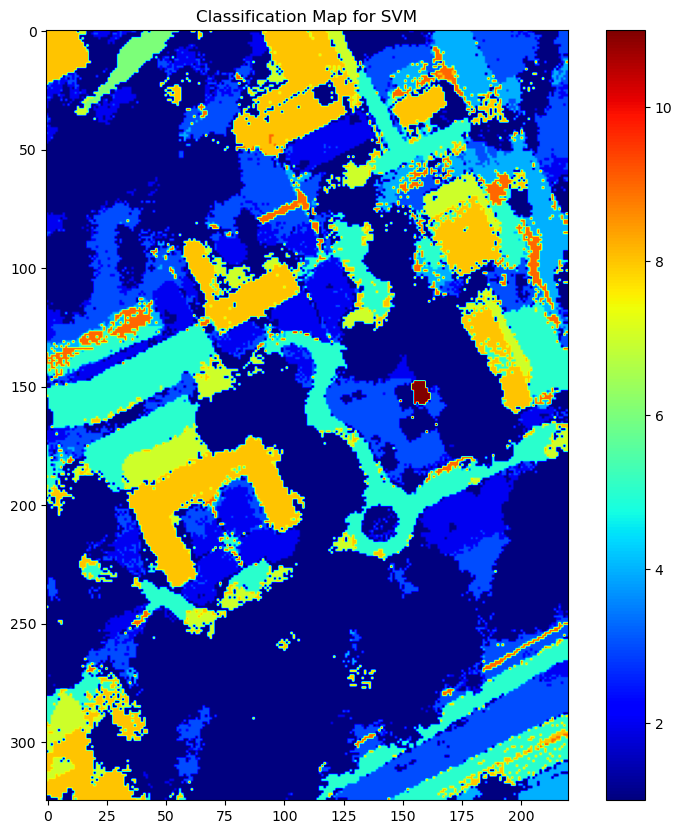

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming best_svm_model is your trained SVM model
# and Vectors_scaled contains the entire dataset after scaling

# Predict the entire dataset using the best SVM model
full_pred_svm = best_svm_model.predict(Vectors_scaled)

# Reshape the prediction back to the original image shape
classification_map_svm = np.zeros(img_gt.shape)
classification_map_svm.flat = full_pred_svm

# Plot the classification map for SVM
plt.figure(figsize=(10, 10))
plt.imshow(classification_map_svm, cmap='jet')
plt.title('Classification Map for SVM')
plt.colorbar()
plt.show()


In [56]:
# RF Hyperparameter tuning using GridSearchCV
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(trainVectors, trainLabels)

# Print the best parameters found for RF
print("Best parameters for RF:", rf_grid_search.best_params_)

# Get the best RF model
best_rf_model = rf_grid_search.best_estimator_

# RF test
rf_testLabel_est = best_rf_model.predict(testVectors)

# Convert RF predictions to match testLabels if necessary
rf_unique_labels_testLabels = np.unique(testLabels)
rf_unique_labels_testLabel_est = np.unique(rf_testLabel_est)

rf_testLabel_est_mapped = np.zeros_like(rf_testLabel_est)
for i, label in enumerate(rf_unique_labels_testLabel_est):
    if label in rf_unique_labels_testLabels:
        rf_testLabel_est_mapped[rf_testLabel_est == label] = label
    else:
        rf_testLabel_est_mapped[rf_testLabel_est == label] = 0  # Replace with a placeholder label (0 or any unused label)

# Ensure the shapes match for RF confusion matrix calculation
if len(np.unique(rf_testLabel_est_mapped)) > len(rf_unique_labels_testLabels):
    rf_testLabel_est_mapped = rf_testLabel_est_mapped[:-1]

# Performance evaluation for RF with mapped labels
rf_OA = accuracy_score(testLabels, rf_testLabel_est_mapped)
rf_conf_mat = confusion_matrix(testLabels, rf_testLabel_est_mapped)
#rf_kappa = cohen_kappa_score(testLabels, rf_testLabel_est_mapped)


C:\Users\Mrlaptop\anaconda3\anaconda\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for RF: {'max_depth': 20, 'n_estimators': 200}


In [57]:
print("\nRF Accuracy metrics:")
print(f"Overall Accuracy (%): {rf_OA * 100:.2f}")
#print(f"Cohen's Kappa (%): {rf_kappa * 100:.2f}")
print(f"Confusion matrix: {rf_conf_mat}")


RF Accuracy metrics:
Overall Accuracy (%): 83.84
Confusion matrix: [[21669   220   446    20   133     0   126   149    17     1     0]
 [  253  3163   735     0    13     0     0    11     9     0     0]
 [  487   666  5410    31    89     0     0    17    37     0     7]
 [   39     2   609  1067     5     0     0    12    54     1     0]
 [  172    10   120    17  5683     0    20   479    49     3     0]
 [   96     2     1     0     0   284    73     0     0     0     0]
 [  578    28    31     3    73     0  1191   268    16     0     0]
 [  219    34    34    32   547     0   167  5064    18     0     0]
 [  113    87   392   121   112     0     0   110   418     4     0]
 [   27    35    54     0    43     0     0     7    12     1     0]
 [   57    15    31     0     0     0     0     0     0     0   160]]


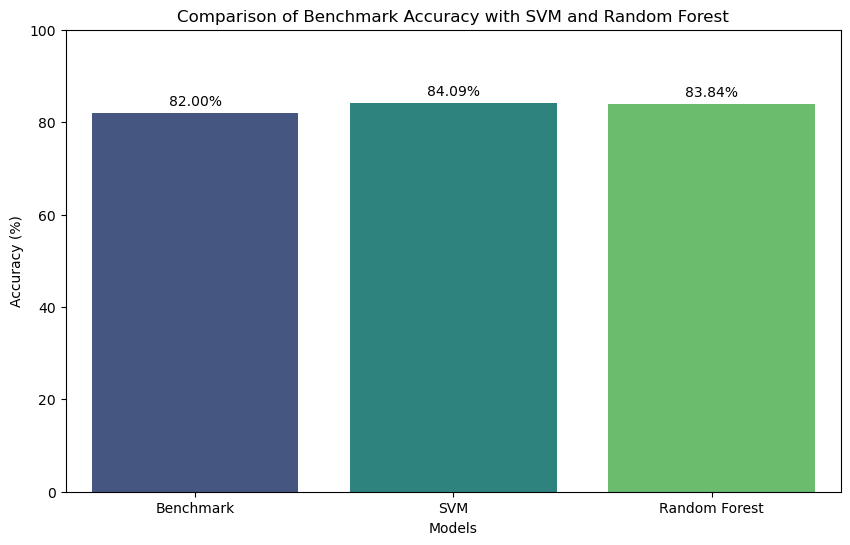

In [58]:
import seaborn as sns
# Assuming you have a benchmark accuracy value
benchmark_accuracy = 0.82  # Replace with your actual benchmark accuracy value

# Create a bar plot for the comparison of accuracies
accuracies = [benchmark_accuracy * 100, svm_OA* 100, rf_OA * 100]
labels = ['Benchmark', 'SVM', 'Random Forest']

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=accuracies, palette="viridis")
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Benchmark Accuracy with SVM and Random Forest')
plt.ylim(0, 100)  # Set the y-axis range to 0-100%

# Annotate each bar with the percentage accuracy
for i in range(len(accuracies)):
    plt.text(i, accuracies[i] + 1, f'{accuracies[i]:.2f}%', ha='center', va='bottom')

plt.show()